# ShadowNET Implementation
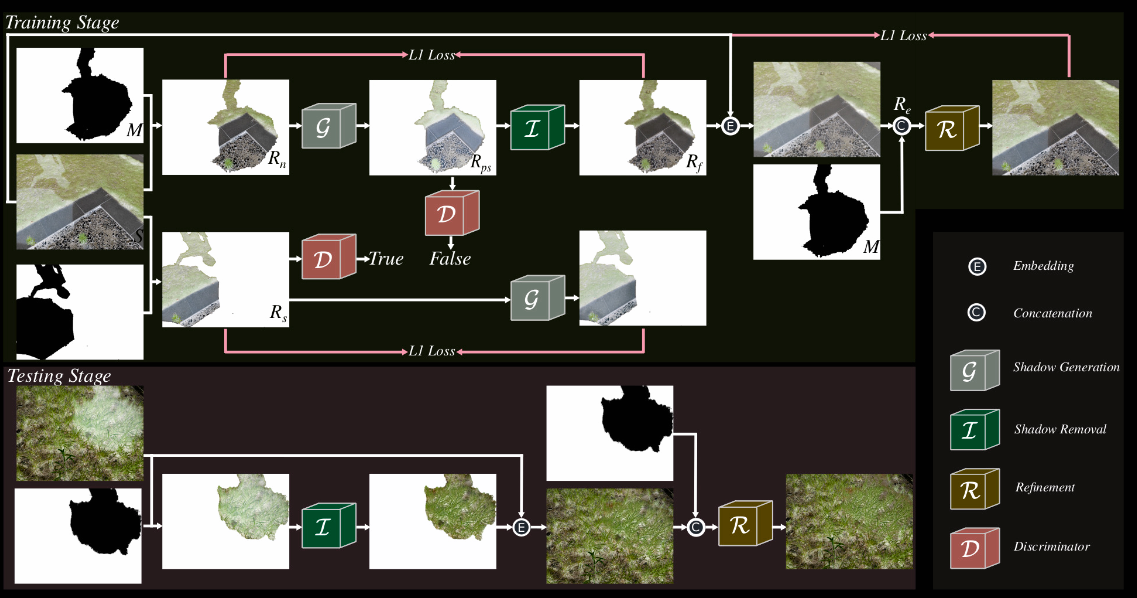

In [1]:
import keras
import tensorflow

2024-12-12 09:17:44.235111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 09:17:44.242232: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 09:17:44.319434: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 09:17:44.382699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734020264.452936   19956 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734020264.46

In [9]:
# download the data set
import kagglehub

path = kagglehub.dataset_download('sabarinathan/istd-dataset')

print("Path to dataset files:", path)


Path to dataset files: /home/joshuat/.cache/kagglehub/datasets/sabarinathan/istd-dataset/versions/1


In [10]:
import pandas as pd

# istd = pd.read_csv(path + 'ISTD_Dataset')

import os
import numpy as np
import cv2

def generate_shadow_training_data(shadow_dir, mask_dir, output_base_dir):
    # Create output directories
    output_dirs = {
        'train_A': os.path.join(output_base_dir, 'train_A'),  # Shadow regions with new mask
        'train_B': os.path.join(output_base_dir, 'train_B'),  # Mask images
        'train_D': os.path.join(output_base_dir, 'train_D'),  # Original shadow regions
        'train_E': os.path.join(output_base_dir, 'train_E'),  # Non-shadow regions
        'train_F': os.path.join(output_base_dir, 'train_F')   # Dilated mask
    }
    
    # Create directories if they don't exist
    for dir_path in output_dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    # Get list of image files
    shadow_images = [f for f in os.listdir(shadow_dir) if f.endswith('.png')]
    mask_images = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    
    for shadow_filename in shadow_images:
        # Read shadow and original mask images
        shadow_path = os.path.join(shadow_dir, shadow_filename)
        shadow_img = cv2.imread(shadow_path) / 255.0
        
        # Read original mask
        original_mask_path = os.path.join(mask_dir, shadow_filename)
        original_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)
        original_nmask = cv2.bitwise_not(original_mask)
        original_smask = original_mask
        
        # Find a suitable new mask
        new_mask = None
        for _ in range(100):
            # Randomly select a new mask
            new_mask_filename = mask_images[np.random.randint(len(mask_images))]
            new_mask_path = os.path.join(mask_dir, new_mask_filename)
            new_mask = cv2.imread(new_mask_path, cv2.IMREAD_GRAYSCALE)
            new_nmask = cv2.bitwise_not(new_mask)
            
            # Compute mask coverage ratio
            new_smask = new_mask
            newmask = cv2.subtract(new_smask.astype(np.uint8), original_smask.astype(np.uint8))
            
            # Check if mask coverage is within acceptable range
            coverage_ratio = np.sum(newmask) / np.sum(original_smask)
            if 0.8 <= coverage_ratio <= 1.2:
                break
        
        # Prepare masks for processing
        newmask_3channel = cv2.merge([newmask, newmask, newmask])
        smask_3channel = cv2.merge([original_smask, original_smask, original_smask])
        
        # Create dilated mask
        kernel = np.ones((50, 50), np.uint8)
        newmask_dilated = cv2.dilate(newmask, kernel)
        
        # Write processed images
        cv2.imwrite(os.path.join(output_dirs['train_A'], shadow_filename), 
                    shadow_img * newmask_3channel)
        cv2.imwrite(os.path.join(output_dirs['train_B'], shadow_filename), 
                    newmask)
        cv2.imwrite(os.path.join(output_dirs['train_D'], shadow_filename), 
                    shadow_img * smask_3channel)
        cv2.imwrite(os.path.join(output_dirs['train_E'], shadow_filename), 
                    shadow_img * cv2.bitwise_not(newmask_3channel))
        cv2.imwrite(os.path.join(output_dirs['train_F'], shadow_filename), 
                    newmask_dilated)

# Example usage
shadow_dir = path + '/ISTD_Dataset/train/train_A'
mask_dir = path + '/ISTD_Dataset/train/train_B'
output_base_dir = 'output'

generate_shadow_training_data(shadow_dir, mask_dir, output_base_dir)


In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Experimental Settings
"We initialise our model using a Gaussian distribution with a mean of 0 and a standard deviation of 0.02. We employ the Adam optimiser to train our network with the first and the second momentum setting to 0.5 and 0.999, respectively. We train the whole model for 100 epochs and the base learning rate is set to 2 × 10−4 for the first 50 epochs and then we apply a linear decay strategy to decrease it to 0 for the rest epochs"

# Implementation of the ShadowGAN
2 discriminators, one local and one global

Input - 256 x 256 x 4
 - 4 channels, rgb and the source object mask m_s

Output - Single Channel Shadow Map of size 256 x 256

# Discriminators


## Local


## Global

